In [1]:
import pandas as pd
import sqlite3
conn = sqlite3.connect('recipe.db')
import matplotlib as plt
from geotext import GeoText

In [2]:
sql = '''SELECT R.tag_value, S.tag_value 
         FROM recipe R 
         JOIN recipe_step RS ON R.ID = RS.recipe_id
         JOIN step S ON RS.step_id = S.ID
         WHERE R.tag_value LIKE '%tomato%' 
         AND R.tag_value LIKE '%soup%'
         ;'''

df_tomato_soup_steps = pd.read_sql(sql, conn)
print("steps")
print(df_tomato_soup_steps)

steps
                          tag_value  \
0      pepper and tomato cream soup   
1      pepper and tomato cream soup   
2      pepper and tomato cream soup   
3      pepper and tomato cream soup   
4      pepper and tomato cream soup   
...                             ...   
13035      my homestyle tomato soup   
13036      my homestyle tomato soup   
13037      my homestyle tomato soup   
13038      my homestyle tomato soup   
13039      my homestyle tomato soup   

                                               tag_value  
0      in a wide-bottomed saucepan, add tomatoes and ...  
1                            cook until peppers are limp  
2       add broth and simmer slowly for about 10 minutes  
3      stir in milk, add salt and hot pepper seasonin...  
4         mix cheese into the soup and serve immediately  
...                                                  ...  
13035                                             season  
13036  cook celery, onion, and green pepper in 1 cup 

In [3]:
sql = '''SELECT R.ID, R.tag_value, N.tag_value 
         FROM recipe R 
         JOIN recipe_ner RN ON R.ID = RN.recipe_id
         JOIN ner N ON RN.ner_id = N.ID
         WHERE R.tag_value LIKE '%tomato%' 
         AND R.tag_value LIKE '%soup%'
         ;'''

df_tomato_soup_ner = pd.read_sql(sql, conn)


print("ingredients")
print(df_tomato_soup_ner.iloc[:,2:3])

ingredients
                     tag_value
0                       cheese
1           green bell peppers
2                         salt
3      liquid hot pepper sauce
4                     tomatoes
...                        ...
13044             green pepper
13045                   celery
13046                 tomatoes
13047                    onion
13048                     milk

[13049 rows x 1 columns]


In [4]:
freq = df_tomato_soup_ner.iloc[:,2:3].value_counts().nlargest(30)

In [5]:
freq

tag_value             
tomatoes                  886
salt                      737
garlic                    674
onion                     503
olive oil                 415
water                     295
basil                     274
sugar                     260
butter                    244
chicken broth             228
celery                    190
fresh basil               170
thyme                     169
pepper                    162
onions                    158
tomato paste              149
milk                      135
carrots                   132
parsley                   131
flour                     127
carrot                    110
heavy cream               105
chicken                   104
oregano                   101
tomato soup               100
chicken stock              96
black pepper               93
extra virgin olive oil     88
parmesan cheese            87
extravirgin olive oil      84
dtype: int64

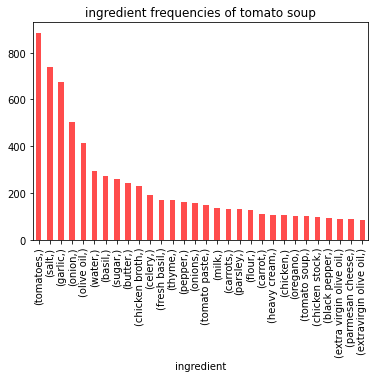

In [6]:
freq.plot(kind="bar", title = "ingredient frequencies of tomato soup", xlabel = 'ingredient', color = 'red', alpha=0.7);

In [7]:
df_tomato_soup_ner.head()

,ID,tag_value,tag_value
0,REC_1015,pepper and tomato cream soup,cheese
1,REC_1015,pepper and tomato cream soup,green bell peppers
2,REC_1015,pepper and tomato cream soup,salt
3,REC_1015,pepper and tomato cream soup,liquid hot pepper sauce
4,REC_1015,pepper and tomato cream soup,tomatoes


In [8]:
# add column count to recipe table
df = df_tomato_soup_ner.copy()
recipe_count = df.groupby(by="ID").count()
recipe_count = recipe_count.iloc[:,1:2].reset_index().rename(columns = {'tag_value':'count'})
dfc = df_tomato_soup_ner.merge(recipe_count, left_on='ID', right_on='ID')

In [9]:
rc = recipe_count.drop_duplicates(subset = 'ID')

In [10]:
rc.describe()

,count
count,1265.000000
mean,10.315415
std,3.655578
min,2.000000
25%,8.000000
50%,10.000000
75%,12.000000
max,43.000000


<AxesSubplot:title={'center':'tomato soup ingredients frequencies'}, xlabel='Frequency', ylabel='number of ingredients'>

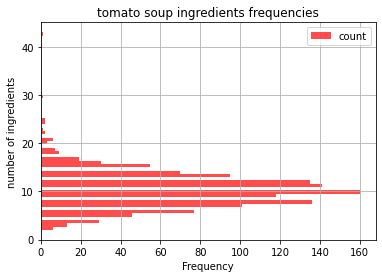

In [11]:
rc.plot(kind='hist',
        alpha=0.7,
        bins=60,
        title='tomato soup ingredients frequencies',
        grid=True,
        orientation='horizontal',
        color=['red'],
        ylabel = "number of ingredients")

# Get source information

I tried a library geotext to find a hint for the origin https://geotext.readthedocs.io/en/latest/readme.html 
It uses the words of the recipe title to get the country keys. I downloaded the country information from https://www.geonames.org/countries/

In [31]:
# Get origin
def get_origin(text):
    """ 
    function that searches for countries associated with a text
    The words of the text needs to be capitalized and seperated by a comma
    The Geotext returns a list of country abbreviations (isocodes)
    It uses the country information from https://www.geonames.org/countries/ 
    to relate the name of the country to the isocode
    
    input: Text
    output: country names seperated by space
    
    """
    countries = get_countries()
    t = ""
    textlist = text.split(" ")
    textlist = [word.capitalize() for word in textlist]
    text = ",".join(textlist)
    result = GeoText(text).country_mentions.keys()
    for i in result:
        try:
            t += countries.loc[countries['iso2'] == i.strip()]['country'].values[0] + ' '
        except:
            try:
                t += {countries.loc[countries['fips'] == i.strip()]['country'].values[0]} + ' '
            except:
                t = i
    return t


def get_countries():
    return pd.read_csv('countries', sep = '\t')

# Fetch the selection from the database

In [61]:
sql = '''SELECT R.tag_value FROM recipe R 
         WHERE  R.tag_value LIKE '%soup%'
         ;'''

dft = pd.read_sql(sql, conn)

# get top 15 origin countries and plot them

In [62]:

dft['origin'] = dft['tag_value'].apply(get_origin)
dft = dft[dft.origin != '']
dfnlargest = dft.origin.value_counts().nlargest(15)

<AxesSubplot:title={'center':'Top 15'}>

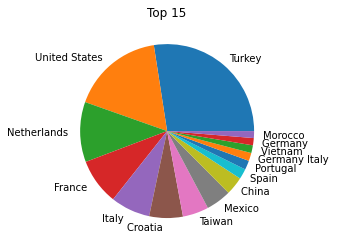

In [65]:
dfnlargest.plot(kind='pie', ylabel = '', title='Top 15')

In [66]:
dft = dft.rename(columns={'tag_value':'recipe title'})
dft

,recipe title,origin
14,lindas hot and sour soup chinese,China
20,yellow split pea soup,Croatia
22,dijon potato leek soup,France Netherlands
23,hot or cold leek soup,Netherlands
24,pho ga vietnamese chicken noodle soup,Vietnam
...,...,...
20382,roasted sunchoke jerusalem artichoke soup,Israel
20389,chicken thai soup,Taiwan
20393,south of the border cheesy potato soup,Turkey
20394,nilagang patabaka filipino porkbeef broth soup...,Philippines
